In [73]:
import numpy as np
import pandas as pd
import json
import re
import os
import ast
import matplotlib.pyplot as plt

from pymatgen.ext.matproj import MPRester
import json
import matplotlib.pyplot as plt
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

In [74]:
from getpass import getpass
from langchain_openai import ChatOpenAI

os.environ['OPENAI_API_KEY']=getpass(prompt='Enter your OpenAI Token:')
model = ChatOpenAI(model="gpt-3.5-turbo")

Enter your OpenAI Token: ········


In [75]:
os.environ['MP_API_KEY']=getpass(prompt='Enter your MP_API_KEY:')

Enter your MP_API_KEY: ········


In [76]:
from langchain.agents import tool

# In general we would like to 

@tool
def MP_get_entries_chem_sys(elem_list: list) -> list:
    """ Function requests all entries availible in MP in chemical system via MPRester()
    """
    all_symbols = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
                   'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc',
                   'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga',
                   'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb',
                   'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                   'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
                   'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
                   'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl',
                   'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
                   'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md',
                   'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg',
                   'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
    a = MPRester()
    if(set(elem_list) <= set(all_symbols)): 
        entries = a.get_entries_in_chemsys(elem_list)
        compositions=[entry.composition.formula for entry in entries]
    else:
        entries=[]
        compositions=[]
    # entries can overflow the context window size, it may be better to write them in a file    
    return compositions, entries

In [87]:
@tool
def MP_plot_phase_diagram(elem_list: list) -> str:
    """
    Function plots phase disgram for the chemical system defined by the list of elements
    """
    all_symbols = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
                   'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc',
                   'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga',
                   'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb',
                   'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                   'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
                   'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
                   'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl',
                   'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
                   'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md',
                   'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg',
                   'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
    a = MPRester()
    if(set(elem_list) <= set(all_symbols)):
        entries = a.get_entries_in_chemsys(elem_list)
        phased = PhaseDiagram(entries)
        pl = PDPlotter(phasediagram=phased, show_unstable=0.2, show_disorder=True, backend='plotly')  
        pl.show()
    return "Describe phase diagram, in particular list stable compounds, and list unstable compounds. \
    Do you think there are other stable compounds in this chemical system?"

Note that passing intermediate information such as entries or phased between functions is problematic due to data type issue (agent can't work with complicated data types without help. And in this case it is complicated.

In [88]:
tools = [MP_get_entries_chem_sys, MP_plot_phase_diagram]

In [89]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events. \
            Check that the input contains the list of chemical elements otherwise cancel",
        ),
        (
            "system",
            "You are very powerful assistant, but don't know current events. Check that the query is about the entries availible\
            in MP in chemical system described by the list or about plotting a phase diagram otherwise cancel",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [90]:
model_with_tools = model.bind_tools(tools)

In [91]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.memory import ChatMessageHistory, ConversationBufferMemory

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | model_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [92]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

### Test drive of the agent

In [94]:
lst=list(agent_executor.stream({"input": "How many entries are availible in chemical system ['Ca','O']?Are there any repetitions? \
How many of those contain both elements? Make a list of material-ids.\
Which material has the lowest energy per atom (Final)? Print the value of energy per atom. Print its chemical formula and material-id."}))



> Entering new AgentExecutor chain...

Invoking: `MP_get_entries_chem_sys` with `{'elem_list': ['Ca', 'O']}`




Retrieving ThermoDoc documents:   0%|          | 0/49 [00:00<?, ?it/s]

(['Ca2', 'Ca8', 'Ca1', 'Ca2', 'Ca1', 'Ca4', 'Ca1', 'Ca4', 'Ca1', 'Ca4', 'Ca1', 'Ca1', 'Ca50 O50', 'Ca2 O2', 'Ca16 O24', 'Ca1 O1', 'Ca50 O50', 'Ca4 O8', 'Ca4 O4', 'Ca50 O50', 'Ca2 O2', 'Ca4 O4', 'Ca1 O2', 'Ca2 O20', 'Ca1 O2', 'Ca1 O2', 'Ca2 O20', 'O8', 'O12', 'O12', 'O1', 'O1', 'O4', 'O8', 'O6', 'O10', 'O2', 'O8', 'O2', 'O6', 'O2', 'O24', 'O2', 'O4', 'O2', 'O12', 'O1', 'O2', 'O8'], [mp-1064227-GGA ComputedStructureEntry - Ca2          (Ca)
Energy (Uncorrected)     = -3.9969   eV (-1.9985  eV/atom)
Correction               = 0.0000    eV (0.0000   eV/atom)
Energy (Final)           = -3.9969   eV (-1.9985  eV/atom)
Energy Adjustments:
  None
Parameters:
  potcar_spec            = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}]
  is_hubbard             = False
  hubbards               = {}
  run_type               = GGA
Data:
  oxide_type             = None
  aspherical             = True
  last_updated           = 2020-11-12 01:39:55.907000
  task_id    

#### Note: Actually correct answer is 49 entries overall (20 if we take set from the list) and 15 contain both elements (8 if we take set from the list). There are also compounds with the same composition, but different formulas, which LLM sould not be able to deal with without special tools.



> Entering new AgentExecutor chain...

Invoking: `MP_plot_phase_diagram` with `{'elem_list': ['Ca', 'O']}`




Retrieving ThermoDoc documents:   0%|          | 0/49 [00:00<?, ?it/s]

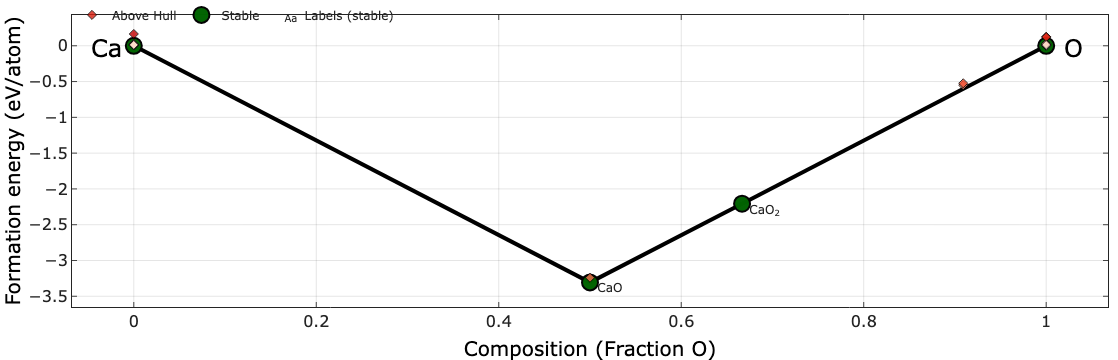

Describe phase diagram, in particular list stable compounds, and list unstable compounds.     Do you think there are other stable compounds in this chemical system?In the phase diagram of the chemical system ['Ca', 'O'], the stable compounds are Calcium Oxide (CaO) and Calcium Peroxide (CaO2). The unstable compounds in this system are not explicitly mentioned in the phase diagram. 

There may be other stable compounds in this chemical system that are not shown in the phase diagram. Would you like me to check for all entries available in the Materials Project for this chemical system to see if there are any other stable compounds?

> Finished chain.


In [95]:
lst=list(agent_executor.stream({"input": "Can you plot a phase diagram for chemical system ['Ca','O']?"}))

Attempt to access API in a more general manner using interface between OpenAPI and chains

In [99]:
# import json
# from openapi_pydantic import OpenAPI
# from langchain_community.utilities.openapi import OpenAPISpec
# from langchain.chains.openai_functions.openapi import get_openapi_chain
# from langchain_core.messages import HumanMessage, SystemMessage

# with open('mp_openapi.json','r') as file:
#     docs=json.load(file)
# specs=OpenAPISpec.from_spec_dict(docs)

# llm = OpenAI(temperature=0)
# chain = get_openapi_chain(specs,llm,verbose=True)

In [100]:
from langchain.chains import APIChain
from langchain.chains.api import open_meteo_docs
from langchain_openai import OpenAI

llm = OpenAI(temperature=0)

chain = APIChain.from_llm_and_api_docs(
    llm,
    api_docs='https://api.materialsproject.org/docs',
    headers={"X-Api-Key": os.environ['MP_API_KEY']},
    verbose=True,
    limit_to_domains=["https://api.materialsproject.org/"],
)

chain.run([SystemMessage(content="You are a helpful assisant and you can help to generate correct api calls."),\
              HumanMessage(content="Download summary for material_id mp-149")])

/Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning:

The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.





> Entering new APIChain chain...
 https://api.materialsproject.org/materials/mp-149/vasp?API_KEY=YOUR_API_KEY
{"detail":"Not Found"}

> Finished chain.


' The requested material_id mp-149 was not found in the database.'

In [ ]:
## We can see that request is formulated incorrecly. Besides currently it is advices to use MPRester()